# SIR dynamics: find the optimal infectivity matrices.

[Index](0-index.ipynb)

We use the script [7-LSQ_fit_optimal_betamat_exec.py](7-LSQ_fit_optimal_betamat_exec.py) to fit $N^2$ transmission rates every day so as to minimize the sum of square errors with local reports of infection, which we call *optimal* infectivity matrices. The analysis is performed in this notebook.

## Imports and global variables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import os,sys
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, minimize_scalar, Bounds, bracket
import scipy.stats as sst

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

import imageio

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append(str(Path('..') / 'code'))

In [4]:
from functions import func_sir_dX, sir_SI_to_X, sir_X_to_SI, func_sir_dV, guess_scale, get_dTs, plot_scatter

In [5]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [6]:
resfile = resdir / 'safegraph_analysis.hdf5'
complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

File safegraph_analysis has 2188 entries.


In [7]:
figdir = Path('../figures') / '7-LSQ_fit_optimal_betamat'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)

In [8]:
colors = ['darkblue', 'darkgreen']
labels = ["sifit", "nufit"]

## Global variables and other quantities

### Global variables

In [9]:
gamma = 1/10.
ti = '2020-03-01'
# tf = '2020-09-01'
tf = '2021-02-16'

tfmt = '%Y-%m-%d'
ti = datetime.datetime.strptime(ti, tfmt)
tf = datetime.datetime.strptime(tf, tfmt)

exts = ['.png', '.svg']

### Load clusters to get population

In [10]:
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    clusters = store[key]
# clusters = pd.read_hdf(resfile, key)
N = len(clusters)
print(f"N = {N}")
clusters

N = 1024


,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728,8705.198547
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287,10942.351090
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530,28389.915254
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126,9988.154964
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598,12057.116223
...,...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209,22780.496368
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047,21868.060533
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290,7878.004843


In [11]:
population = clusters['population'].to_numpy()
population_inv = np.zeros(population.shape, dtype=np.float_)
idx = population > 0.
population_inv[idx] = 1./population[idx]

### Load CSSEGI data

In [12]:
path = '/clustering/cssegi'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    df_cssegi = store[path]

times = df_cssegi.index
idx = (times >= ti) & (times <= tf)
df_cssegi.drop(index=times[~idx], inplace=True)
times = df_cssegi.index.to_pydatetime().tolist()
df_cssegi

index,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
2020-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-12,0,0,0,0,0,0,0,0,1215,239,...,0,0,397,0,181,21712,0,2540,2239,0
2021-02-13,0,0,0,0,0,0,0,0,1221,241,...,0,0,397,0,181,21758,0,2549,2241,0
2021-02-14,0,0,0,0,0,0,0,0,1227,241,...,0,0,397,0,181,21794,0,2553,2244,0
2021-02-15,0,0,0,0,0,0,0,0,1231,241,...,0,0,397,0,181,21817,0,2561,2244,0


In [13]:
omega_real = df_cssegi.to_numpy().astype('float64')
domega_real = np.diff(omega_real, axis=0)
domega_real = np.concatenate([omega_real[0].reshape(1,-1), domega_real], axis=0)

In [14]:
# compute the real epidemic sizes per community through time
Ts_real = np.einsum('ta,a->ta', omega_real, population_inv)
Ss_real = 1. - Ts_real
Ss_real[~(Ss_real > 0.)] = np.finfo(np.float64).resolution
dTs_real = np.einsum('ta,a->ta', domega_real, population_inv)
T_tot_real = np.einsum('ta,a->t', Ts_real, population) / np.sum(population)
S_tot_real = np.einsum('ta,a->t', Ss_real, population) / np.sum(population)
dT_tot_real = np.einsum('ta,a->t', dTs_real, population) / np.sum(population)

Show the total epidemic size from real data

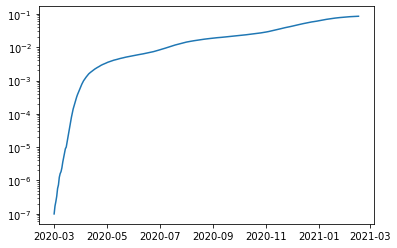

In [15]:
plt.plot(times, T_tot_real)
plt.gca().set_yscale('log')

Show the initial condition

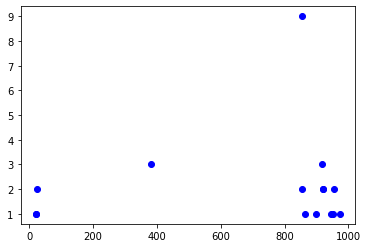

In [16]:
X = clusters.index.to_numpy()
Y = np.einsum('ta,a->ta', Ts_real, population)[0]
idx = Y > 0
plt.plot(X[idx],Y[idx], 'bo')

Define the V-vector

In [17]:
Vs_real = -np.log(Ss_real/Ss_real[0])

## Integrate the dynamics based on the (S,I) variables

In [18]:
Ls_sifit = np.zeros((len(times)-1, N, N), dtype=np.float_)
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    path = Path('/fit') / 'betamat_sifit' / 'infectivity_matrices'
    for i in range(len(times)-1):
        mykey = str(path / times[i].strftime(tfmt))
        Ls_sifit[i-1] = store[mykey].to_numpy().astype('float64')

    path = Path('/fit') / 'betamat_sifit' / 'result'
    mykey = str(path / 'susceptible')
    Ss_sifit = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_sifit = store[mykey].to_numpy().astype('float64')

dTs_sifit, dTs_tot_sifit = get_dTs(Ss_sifit, population)

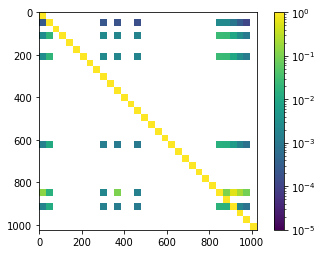

In [19]:
from functions import show_image
vmin = 1.0e-5
fig = show_image(Ls_sifit[0], downscale=2**5, log=True, mpl=True, vmin=vmin, method='max')

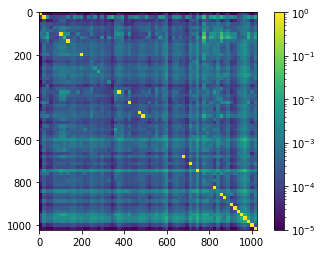

In [20]:
from functions import show_image
vmin = 1.0e-5
fig = show_image(Ls_sifit[100], downscale=2**4, log=True, mpl=True, vmin=vmin, method='max')

In [21]:
Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_sifit, population)
idump = 10
vmin = 1.0e0
vmax = 1.0e6
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
fname = 'T_model_vs_real_sifit'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=True, fpaths=fpaths)

Written file: ../figures/7-LSQ_fit_optimal_betamat/T_model_vs_real_sifit.png
Written file: ../figures/7-LSQ_fit_optimal_betamat/T_model_vs_real_sifit.svg


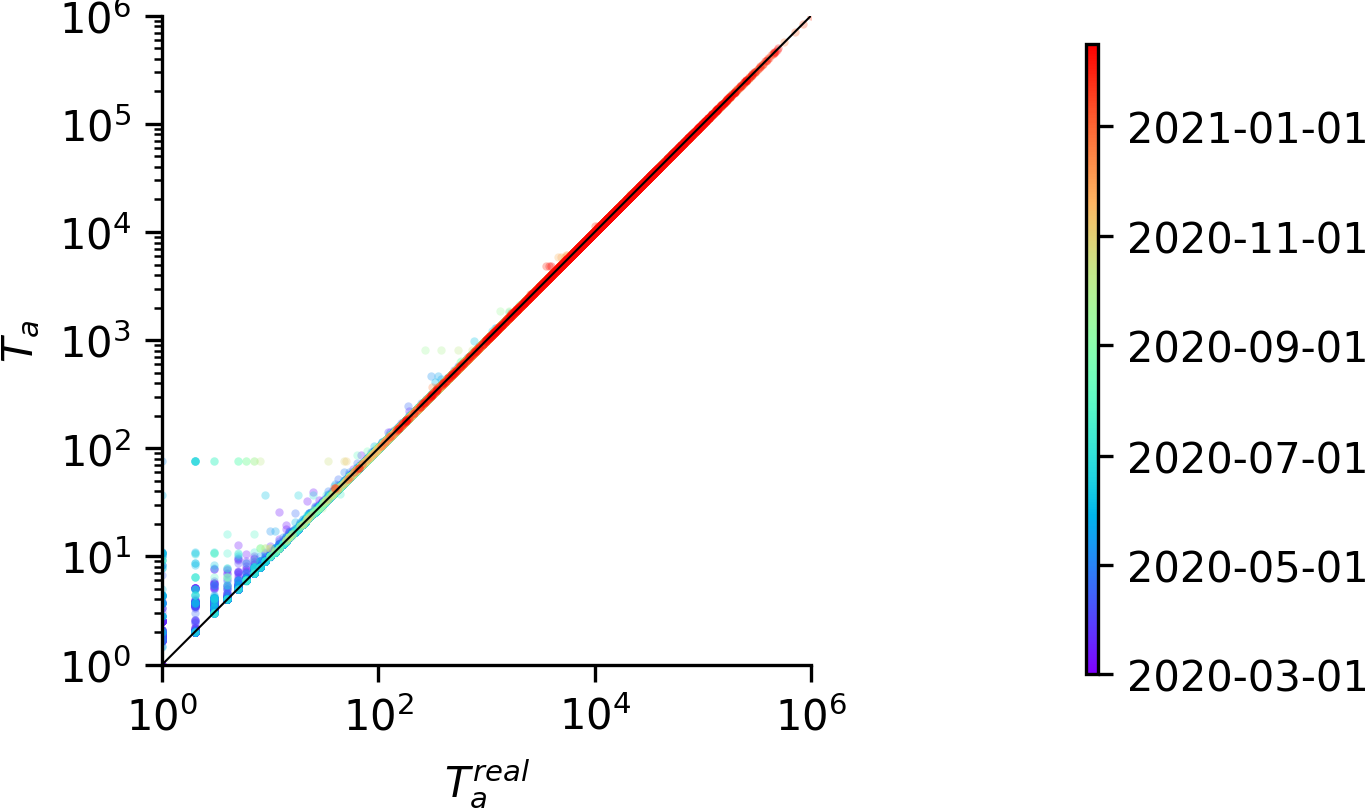

In [22]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [23]:
figsize = None
dpi = 300
idump = 1
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
alpha = 1.
a = 10
logscale = False
vmin = 1.0e0
vmax = 1.0e6
logscale = True

outputdir = figdir / 'time_T_model_vs_real_sifit'
if not outputdir.is_dir():
    outputdir.mkdir(parents=True, exist_ok=True)

Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_sifit, population)
    
for i in range(len(times)):
    fname = times[i].strftime(tfmt)
    fpaths = [outputdir / (fname + ext) for ext in exts]
    
#     vmin, vmax = (np.percentile(Ys[i], 0.5*a), np.percentile(Ys[i], (100-0.5*a)))
    plot_scatter(times[i:i+1], Xs[i:i+1], Ys[i:i+1], idump=idump, vmin=vmin,vmax=vmax, alpha=alpha, \
                     xlabel=xlabel, ylabel=ylabel, logscale=logscale, fpaths=fpaths, dpi=dpi, figsize=figsize, verbose=False)

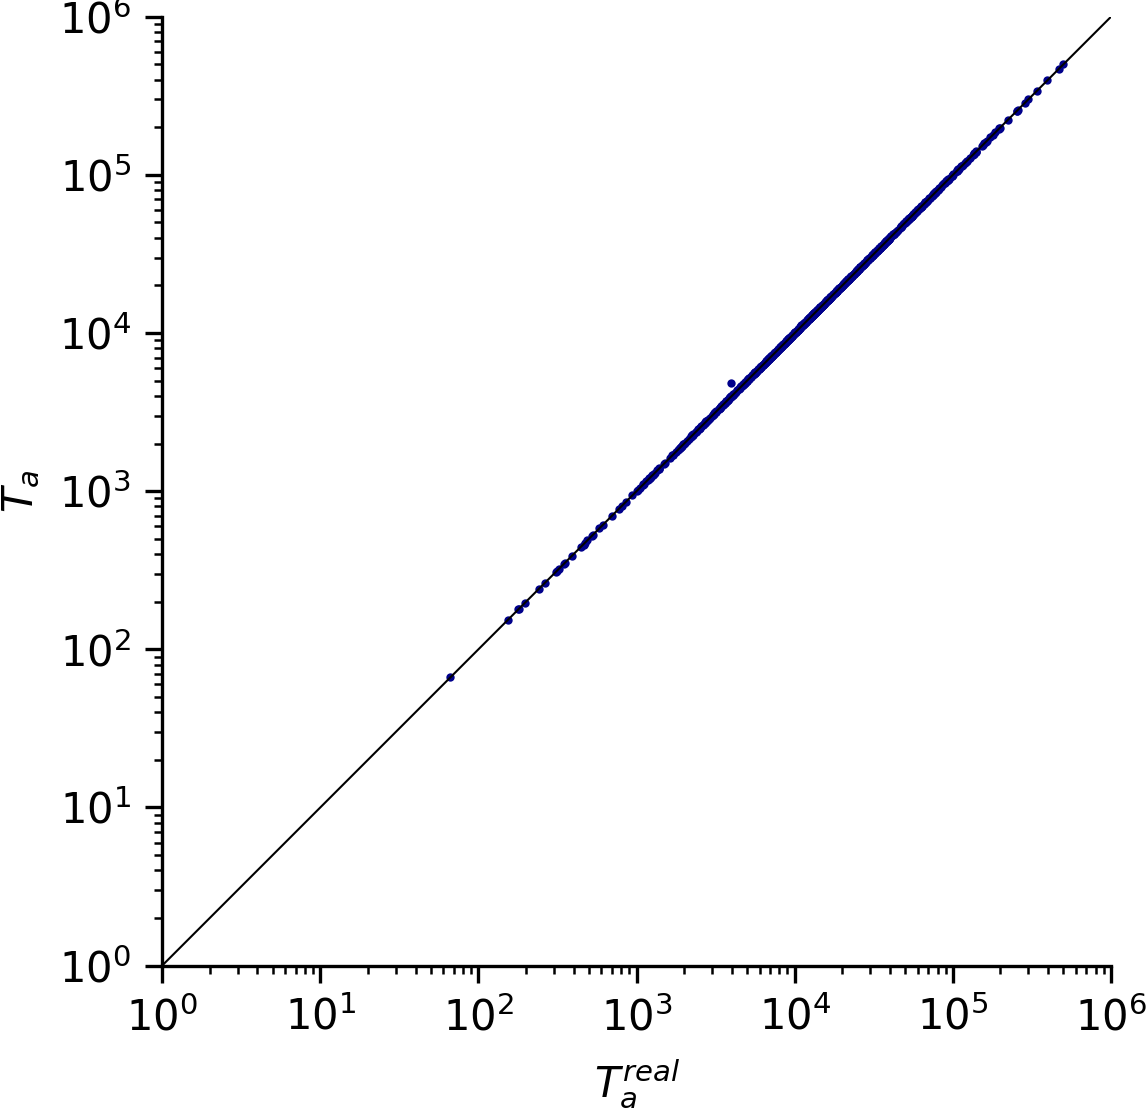

In [24]:
fname = times[i].strftime(tfmt)
filepath = outputdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [25]:
# fbase = 'time_T_model_vs_real_sifit'
# outputdir = figdir / fbase
# files_in = [imageio.imread(outputdir / "{:s}.png".format(t.strftime(tfmt))) for t in times]
# imageio.mimsave(figdir / (fbase + '.mp4'), files_in, fps=5)

In [26]:
Xs = Vs_real
Ys = Vs_sifit
idump = 10
vmin = 1.0e-5
vmax = 2.0e-1
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
fname = 'nu_model_vs_real_sifit'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths)

Written file: ../figures/7-LSQ_fit_optimal_betamat/nu_model_vs_real_sifit.png
Written file: ../figures/7-LSQ_fit_optimal_betamat/nu_model_vs_real_sifit.svg


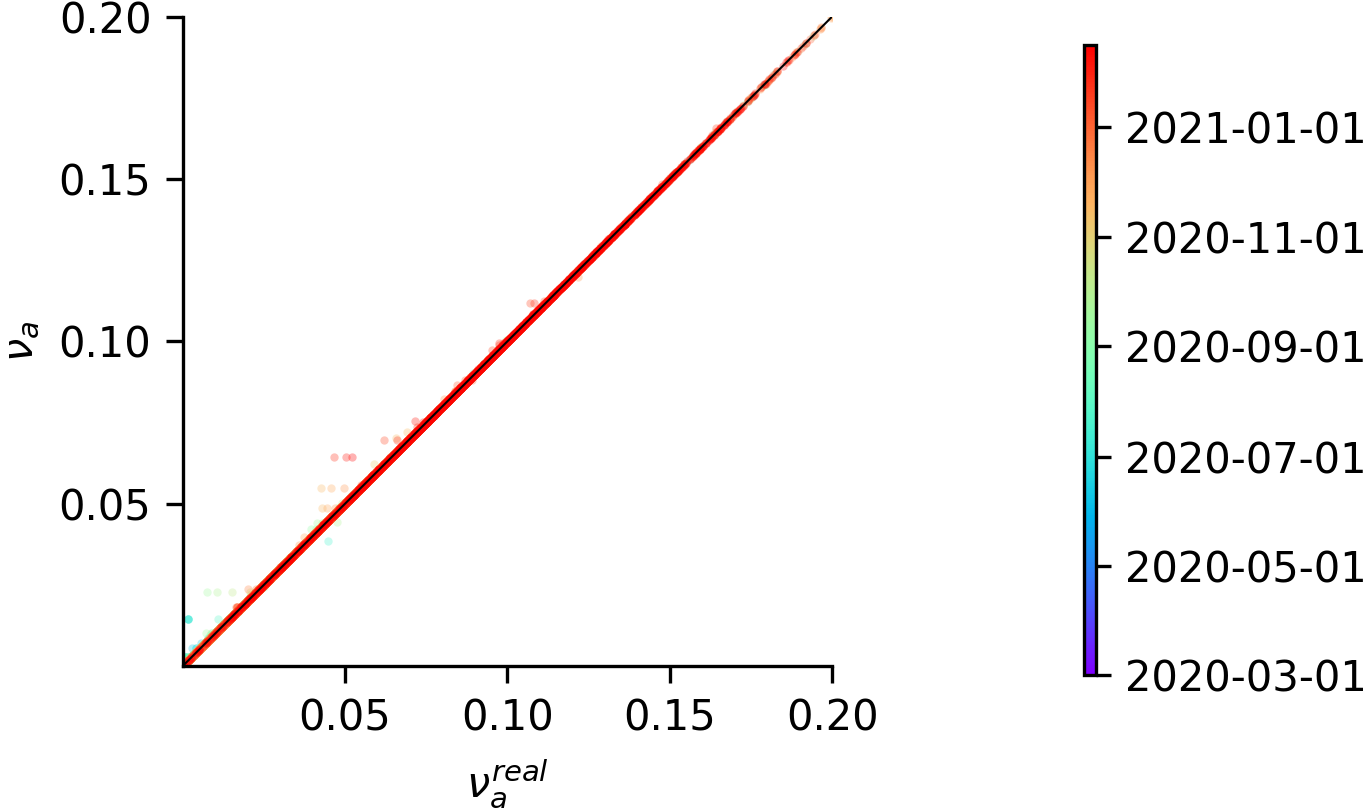

In [27]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [28]:
figsize = (4,3)
dpi = 300
idump = 1
# vmin = 1.0e-5
# vmax = 2.0e-1
vmin = None
vmax = None
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
alpha = 1.
a = 10

outputdir = figdir / 'time_nu_model_vs_real_sifit'
if not outputdir.is_dir():
    outputdir.mkdir(parents=True, exist_ok=True)

Xs = Vs_real
Ys = Vs_sifit
    
for i in range(len(times)):
    fname = times[i].strftime(tfmt)
    fpaths = [outputdir / (fname + ext) for ext in exts]
    
    vmin, vmax = (np.percentile(Ys[i], 0.5*a), np.percentile(Ys[i], (100-0.5*a)))
    plot_scatter(times[i:i+1], Xs[i:i+1], Ys[i:i+1], idump=idump, vmin=vmin,vmax=vmax, alpha=alpha, \
                     xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths, dpi=dpi, figsize=figsize, verbose=False)

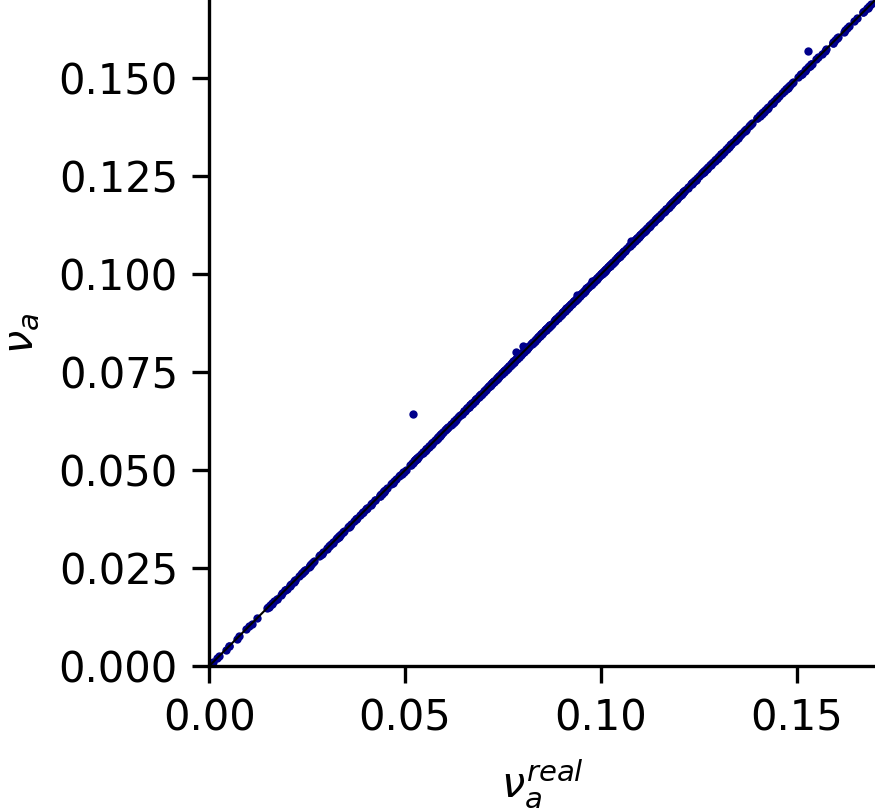

In [29]:
fname = times[i].strftime(tfmt)
filepath = outputdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Integrate the dynamics based on the nu variables

In [30]:
Ls_nufit = np.zeros((len(times)-1, N, N), dtype=np.float_)
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    path = Path('/fit') / 'betamat_nufit' / 'infectivity_matrices'
    for i in range(len(times)-1):
        mykey = str(path / times[i].strftime(tfmt))
        Ls_nufit[i-1] = store[mykey].to_numpy().astype('float64')
    
    path = Path('/fit') / 'betamat_nufit' / 'result'
    mykey = str(path / 'susceptible')
    Ss_nufit = store[mykey].to_numpy().astype('float64')
        
    mykey = str(path / 'nu')
    Vs_nufit = store[mykey].to_numpy().astype('float64')

dTs_nufit, dTs_tot_nufit = get_dTs(Ss_nufit, population)

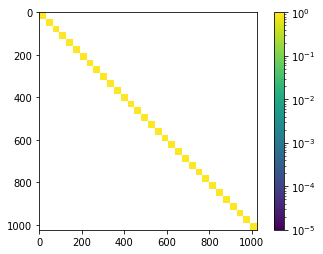

In [31]:
from functions import show_image
vmin = 1.0e-5
fig = show_image(Ls_nufit[0], downscale=2**5, log=True, mpl=True, vmin=vmin, method='max')

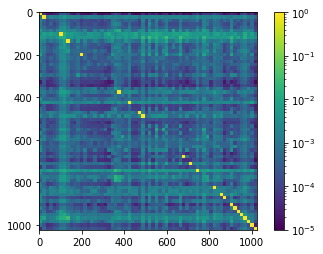

In [32]:
from functions import show_image
vmin = 1.0e-5
fig = show_image(Ls_nufit[100], downscale=2**4, log=True, mpl=True, vmin=vmin, method='max')

In [33]:
Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_nufit, population)
idump = 10
vmin = 1.0e0
vmax = 1.0e6
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
fname = 'T_model_vs_real_nufit'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=True, fpaths=fpaths)

Written file: ../figures/7-LSQ_fit_optimal_betamat/T_model_vs_real_nufit.png
Written file: ../figures/7-LSQ_fit_optimal_betamat/T_model_vs_real_nufit.svg


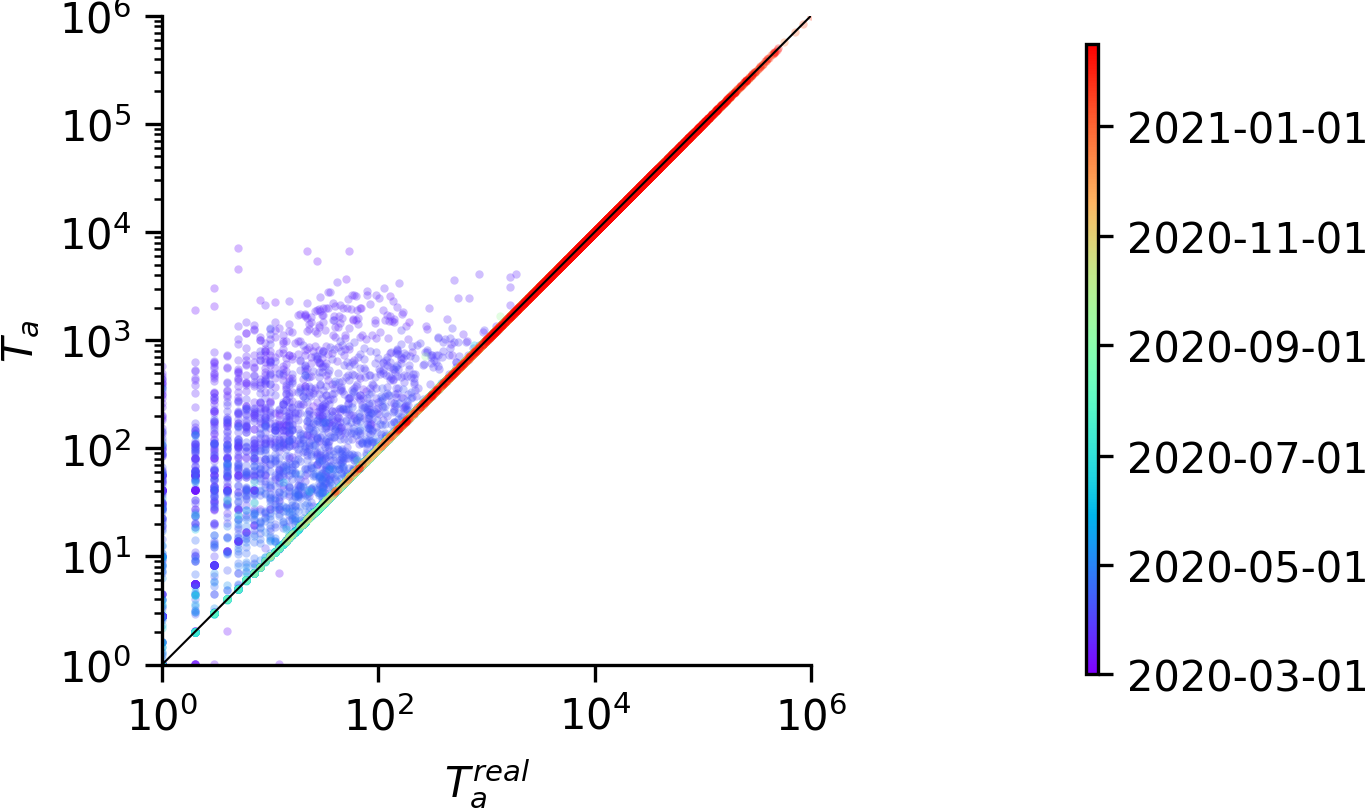

In [34]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [35]:
figsize = (4,3)
dpi = 300
idump = 1
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
alpha = 1.
a = 10
logscale = False
vmin = 1.0e0
vmax = 1.0e6
logscale = True

outputdir = figdir / 'time_T_model_vs_real_nufit'
if not outputdir.is_dir():
    outputdir.mkdir(parents=True, exist_ok=True)

Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_nufit, population)
    
    
for i in range(len(times)):
    fname = times[i].strftime(tfmt)
    fpaths = [outputdir / (fname + ext) for ext in exts]
    
#     vmin, vmax = (np.percentile(Ys[i], 0.5*a), np.percentile(Ys[i], (100-0.5*a)))
    plot_scatter(times[i:i+1], Xs[i:i+1], Ys[i:i+1], idump=idump, vmin=vmin,vmax=vmax, alpha=alpha, \
                     xlabel=xlabel, ylabel=ylabel, logscale=logscale, fpaths=fpaths, dpi=dpi, figsize=figsize, verbose=False)

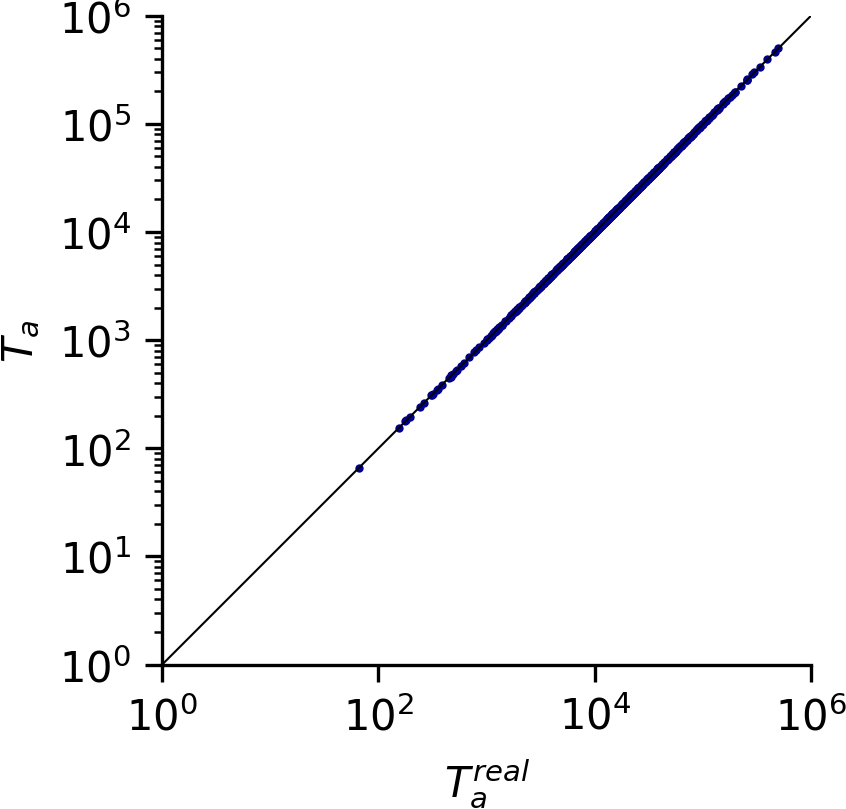

In [36]:
fname = times[i].strftime(tfmt)
filepath = outputdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [37]:
Xs = Vs_real
Ys = Vs_nufit
idump = 10
vmin = 1.0e-5
vmax = 2.0e-1
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
fname = 'nu_model_vs_real_nufit'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths)

Written file: ../figures/7-LSQ_fit_optimal_betamat/nu_model_vs_real_nufit.png
Written file: ../figures/7-LSQ_fit_optimal_betamat/nu_model_vs_real_nufit.svg


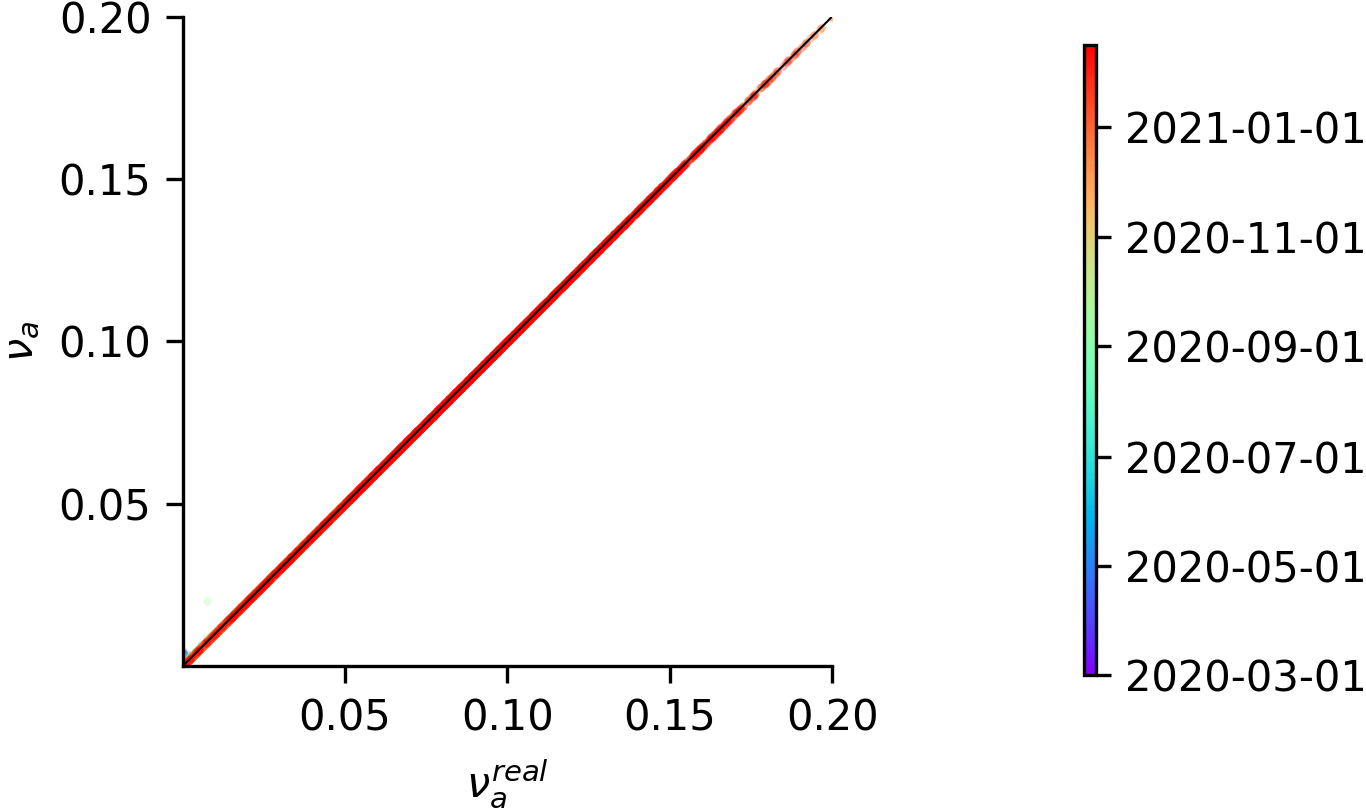

In [38]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [39]:
figsize = (4,3)
dpi = 300
idump = 1
# vmin = 1.0e-5
# vmax = 2.0e-1
vmin = None
vmax = None
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
alpha = 1.
a = 10

outputdir = figdir / 'time_nu_model_vs_real_nufit'
if not outputdir.is_dir():
    outputdir.mkdir(parents=True, exist_ok=True)

Xs = Vs_real
Ys = Vs_nufit
    
for i in range(len(times)):
    fname = times[i].strftime(tfmt)
    fpaths = [outputdir / (fname + ext) for ext in exts]
    
    vmin, vmax = (np.percentile(Ys[i], 0.5*a), np.percentile(Ys[i], (100-0.5*a)))
    plot_scatter(times[i:i+1], Xs[i:i+1], Ys[i:i+1], idump=idump, vmin=vmin,vmax=vmax, alpha=alpha, \
                     xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths, dpi=dpi, figsize=figsize, verbose=False)

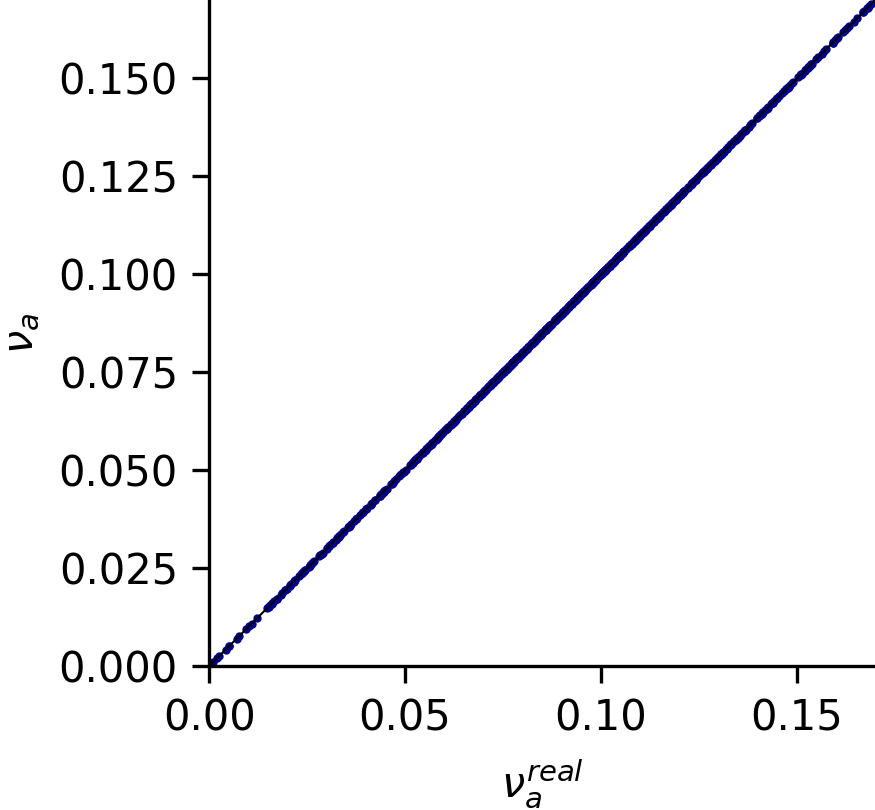

In [40]:
fname = times[i].strftime(tfmt)
filepath = outputdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

## Additional analysis and plots

### Time-dependent

In [41]:
Z_T_sifit = np.einsum('ta,a->ta', Ss_sifit - Ss_real, population)
Z_T_nufit = np.einsum('ta,a->ta', Ss_nufit - Ss_real, population)
print("T_err: {:.6e}    {:.6e}".format(np.linalg.norm(Z_T_sifit)**2, np.linalg.norm(Z_T_nufit)**2))

T_err: 1.729948e+08    5.932540e+09


In [42]:
print("T_tot_err: {:.6e}    {:.6e}".format(np.linalg.norm(np.einsum('ta->t', Z_T_sifit))**2, np.linalg.norm(np.einsum('ta->t', Z_T_nufit))**2))

T_tot_err: 7.656672e+08    1.090653e+12


In [43]:
Z_nu_sifit = Vs_sifit - Vs_real
Z_nu_nufit = Vs_nufit - Vs_real
print("Nu_err: {:.6e}    {:.6e}".format(np.linalg.norm(Z_nu_sifit)**2, np.linalg.norm(Z_nu_nufit)**2))

Nu_err: 7.697094e+04    5.048178e+02


In [44]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=6
lw=1
show_dT=True
n0=None
ptot = np.sum(population) / 1.0e3

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

dT_tot_list = np.array([dTs_tot_sifit, dTs_tot_nufit])

if show_dT:
    for i in range(len(dT_tot_list)):
        ax.plot(times[:n0],dT_tot_list[i,:n0]*ptot, '-', ms=ms, lw=lw, color=colors[i], mfc='none', mew=lw, label=labels[i])
    ax.plot(times[:n0],dT_tot_real[:n0]*ptot, 'o', ms=ms, color='red', mfc='none', mew=lw)
    ax.set_ylabel("$d T$ [x1e3]", fontsize="medium")
    fname = 'dT_tot'
else:
    for i in range(len(dT_tot_list)):
        ax.plot(times[:n0],T_tot_list[i,:n0]*ptot, '-', ms=ms, lw=lw, color=colors[i], mfc='none', mew=lw, label=labels[i])
    ax.plot(times[:n0],T_tot_real[:n0]*ptot, '-', lw=lw, color='red')
    ax.set_ylabel("$T$ [x1e3]", fontsize="medium")
    ax.set_yscale('log')
    fname = 'T_tot'

ax.legend(loc='best', fontsize='medium', frameon=False)
ax.set_xlim(times[0],None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/7-LSQ_fit_optimal_betamat/dT_tot.png
Written file: ../figures/7-LSQ_fit_optimal_betamat/dT_tot.svg


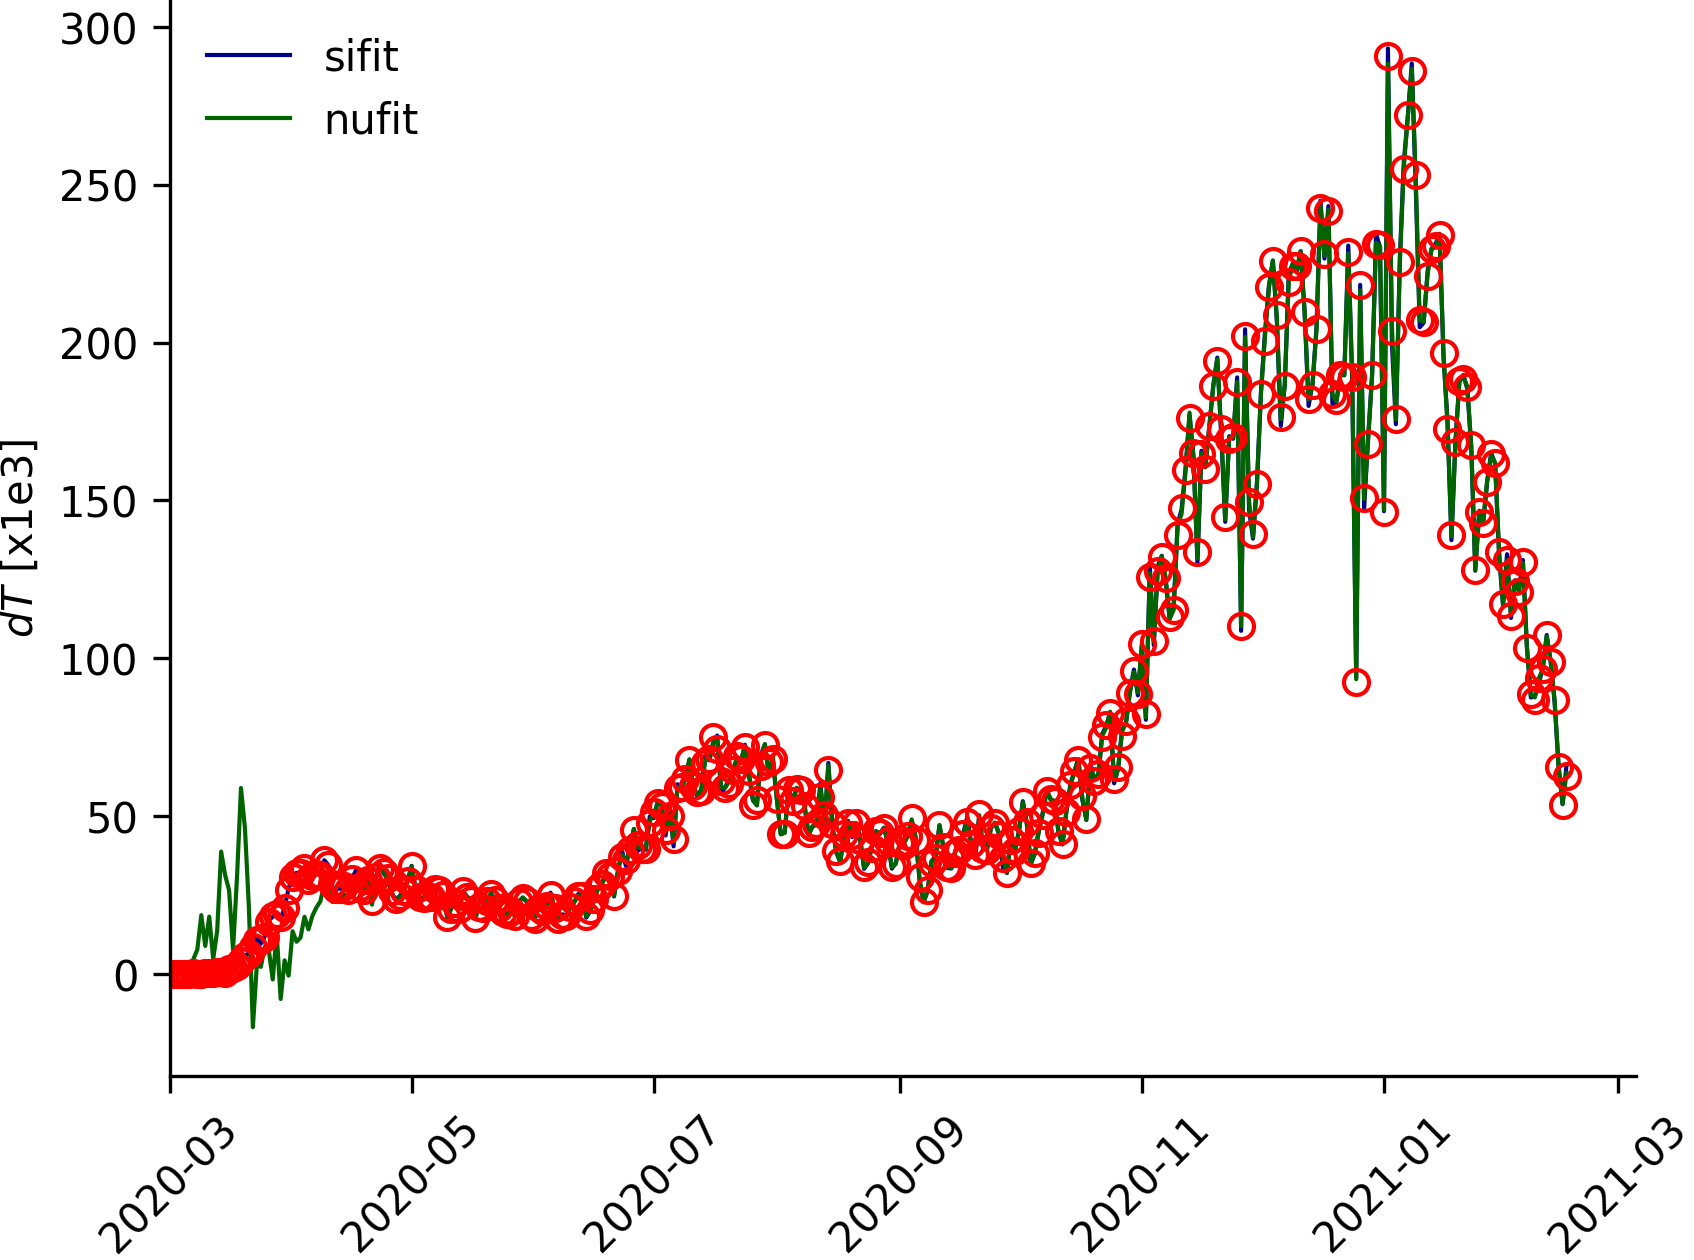

In [45]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [46]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=6
lw=1

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

Z_Ts = np.linalg.norm(np.array([Z_T_sifit, Z_T_nufit]), axis=2) / np.sqrt(N)
colors=['darkblue', 'darkgreen']
labels = ['T', 'nu']
# Z_nus = np.linalg.norm(np.array([Z_nu_sifit, Z_nu_nufit]), axis=2)

for i in range(len(Z_Ts)):
    ax.plot(times,Z_Ts[i], '-', ms=ms, lw=lw, color=colors[i], mfc='none', mew=lw, label=labels[i])

ax.legend(loc='best', fontsize='medium', frameon=False)
ax.set_xlim(times[0],None)
ax.set_ylim(0,None)
ax.set_ylabel("z_T", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'Z_T'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/7-LSQ_fit_optimal_betamat/Z_T.png
Written file: ../figures/7-LSQ_fit_optimal_betamat/Z_T.svg


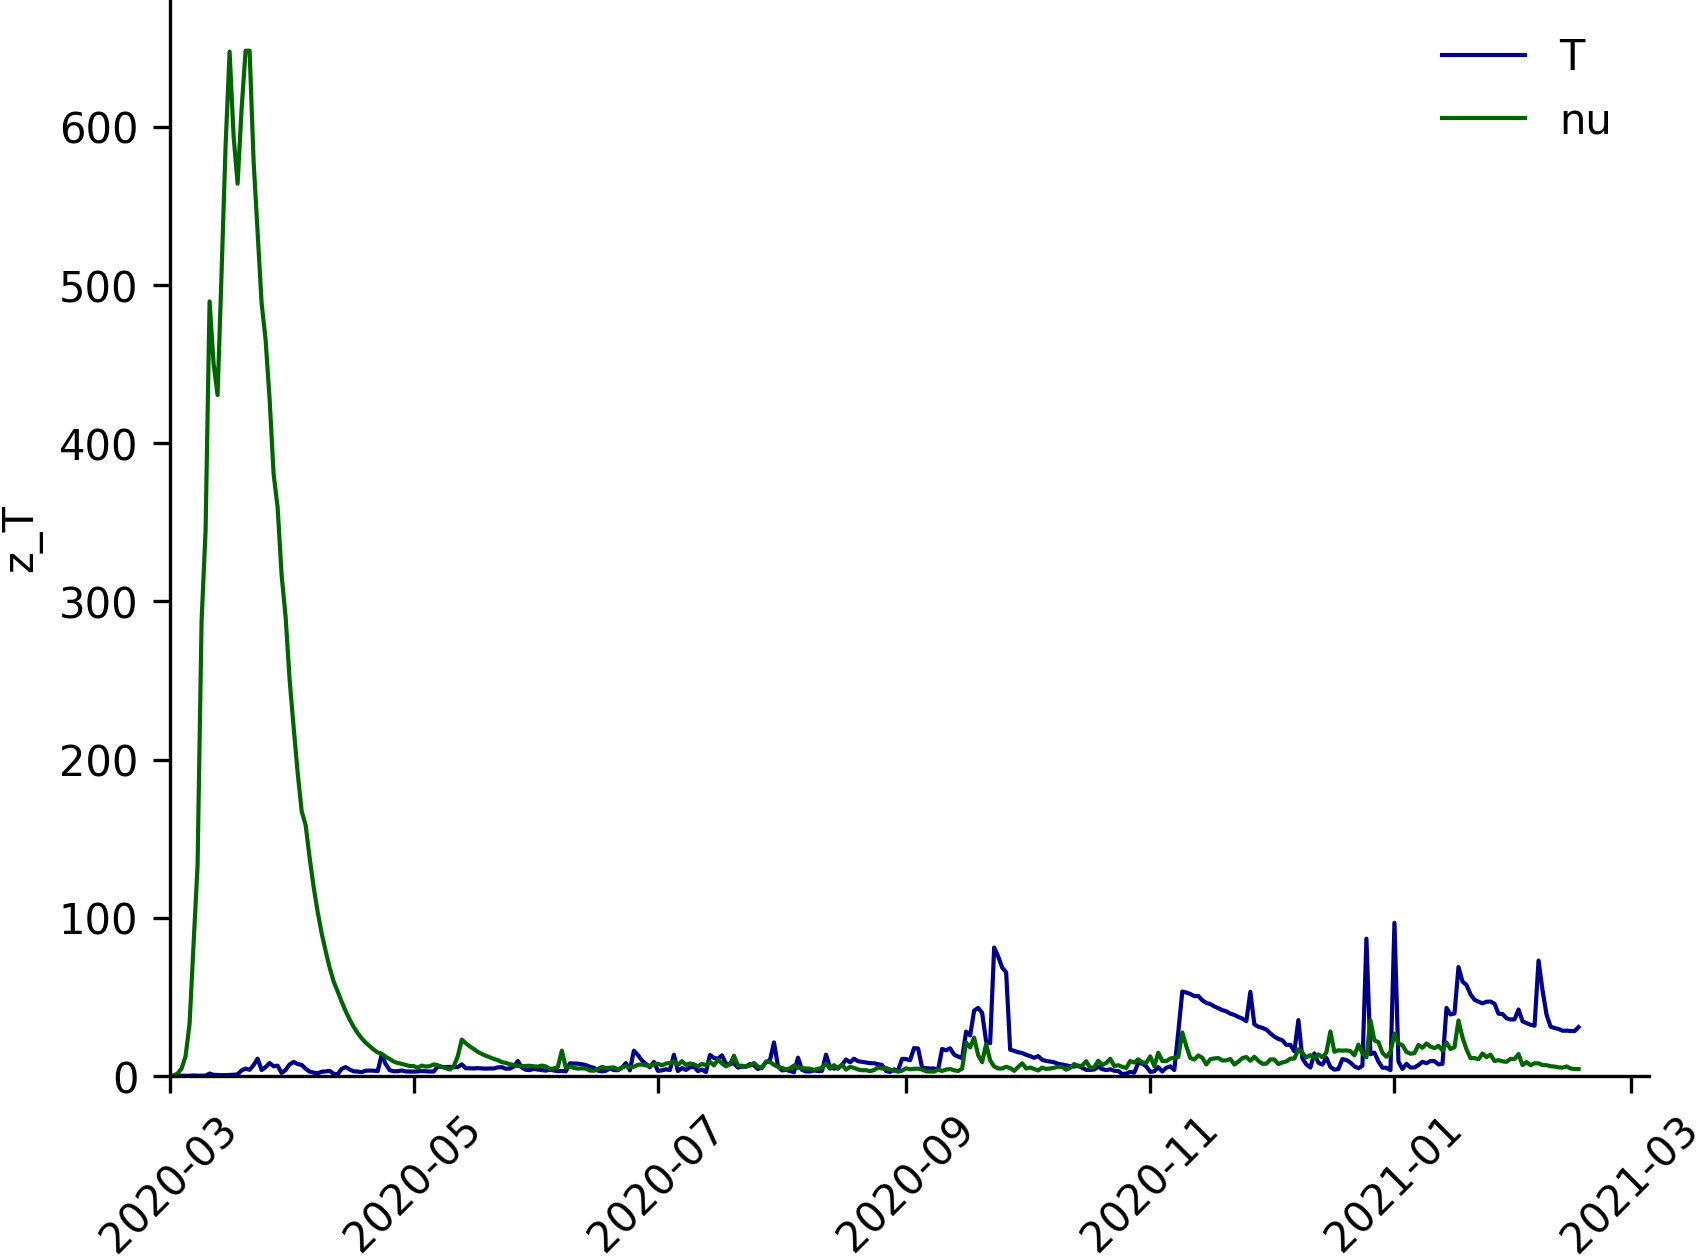

In [47]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [48]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=6
lw=1
ymax=None

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

Z_nus = np.linalg.norm(np.array([Z_nu_sifit, Z_nu_nufit]), axis=2) / np.sqrt(N)
colors=['darkblue', 'darkgreen']
labels = ['T', 'nu']
# Z_nus = np.linalg.norm(np.array([Z_nu_sifit, Z_nu_nufit]), axis=2)

for i in range(len(Z_nus)):
    ax.plot(times,Z_nus[i], '-', ms=ms, lw=lw, color=colors[i], mfc='none', mew=lw, label=labels[i])

ax.legend(loc='best', fontsize='medium', frameon=False)
ax.set_xlim(times[0],None)
ax.set_ylim(0,ymax)
ax.set_ylabel("z_nu", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'Z_nu'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/7-LSQ_fit_optimal_betamat/Z_nu.png
Written file: ../figures/7-LSQ_fit_optimal_betamat/Z_nu.svg


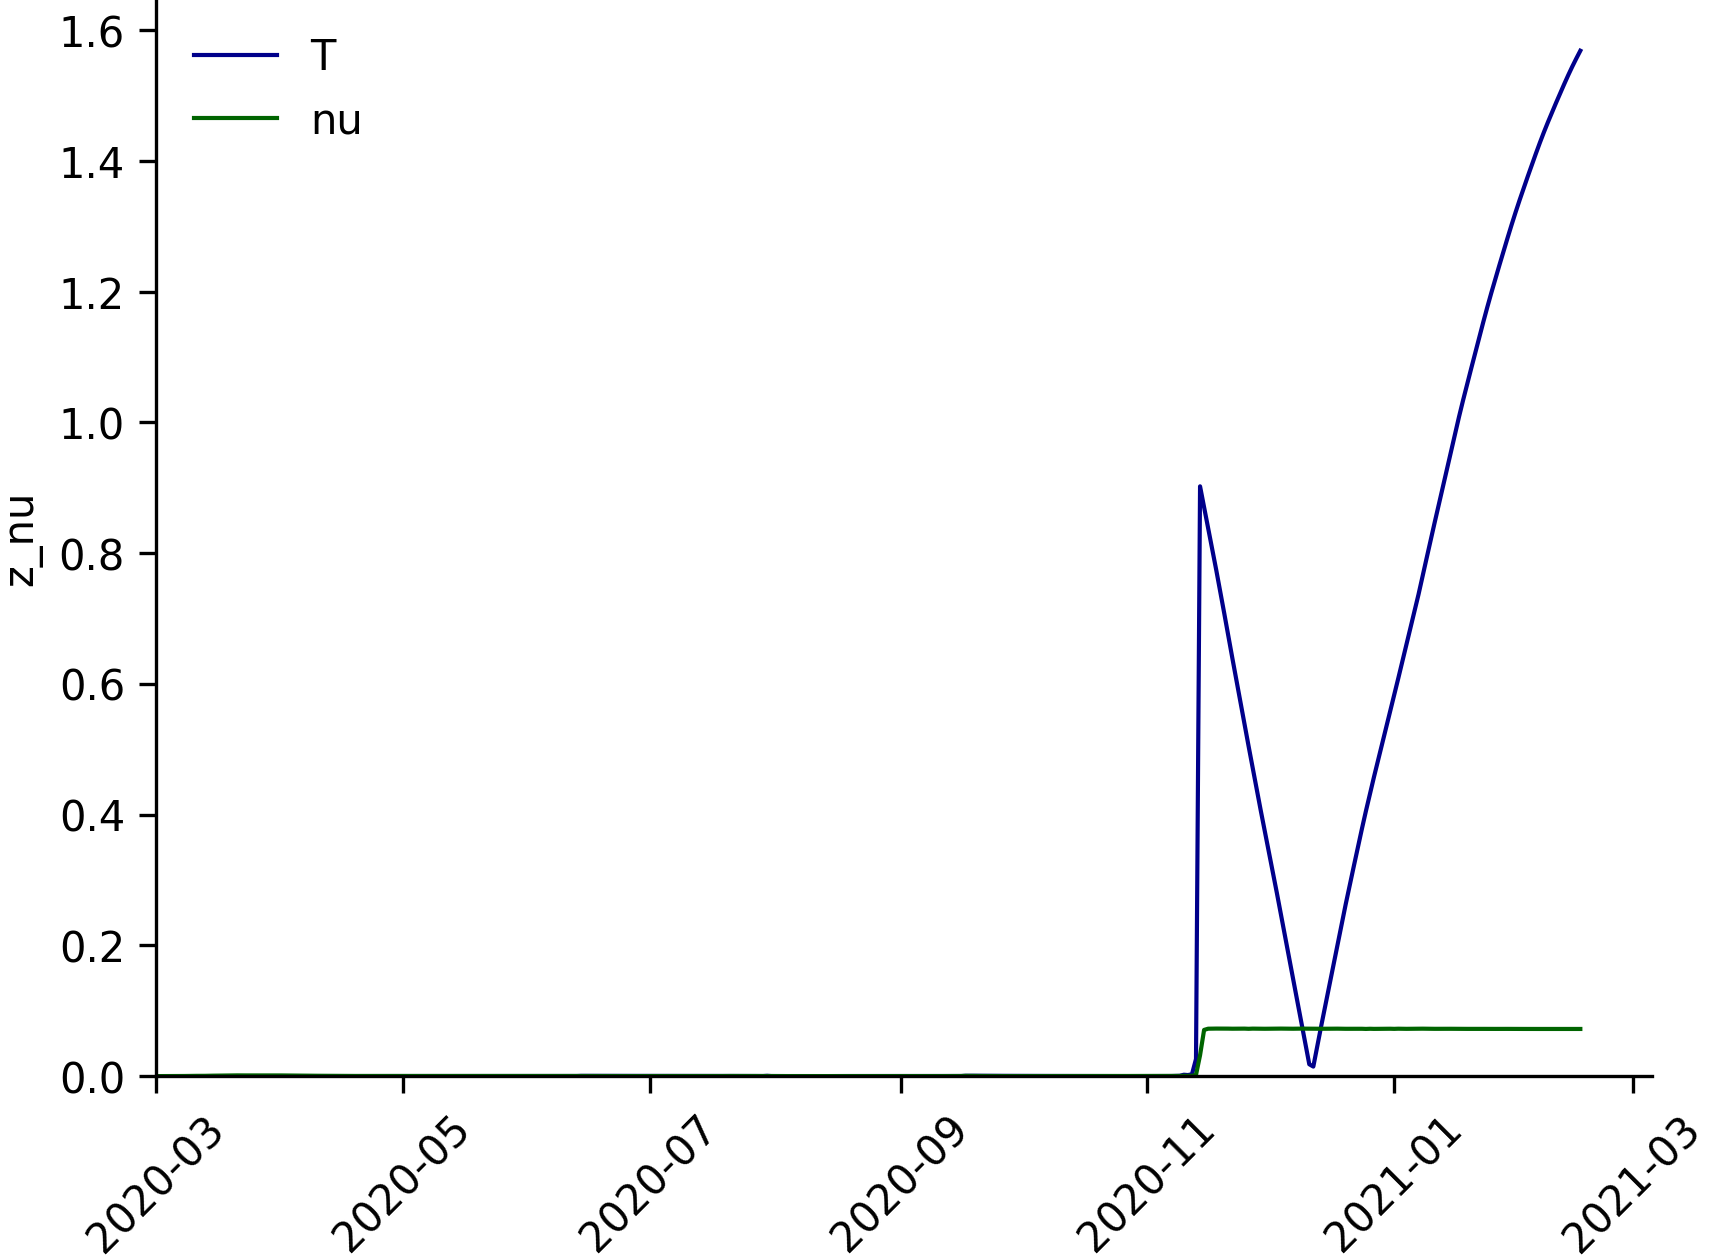

In [49]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

-1.2474284909156903 0.761245986201593
nbins = 405    bwidth = 0.004959528817496173    a = -1.2473696723038221    b = 0.7612394987821329


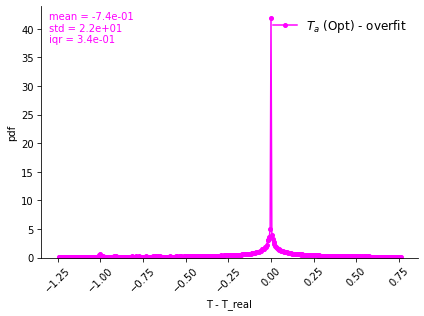

In [50]:
# parameters
figsize = (6,4.5)
dpi = 300
lw=1
ms=4
# bins='doane'
bins='auto'
# bins=2**8
a=20

data_sifit_opt = np.einsum('ta,a->ta', Ss_sifit - Ss_real, population).ravel()
data = data_sifit_opt

q1,q2 = np.percentile(data, [a*0.5, 100-a*0.5])
print(q1, q2)
hist, edges = np.histogram(data[~((data < q1) | (data > q2))], bins=bins, density=True)
print("nbins = {}    bwidth = {}    a = {}    b = {}".format(len(edges)-1, edges[1]-edges[0], edges[0], edges[-1]))

hist_sifit_opt, edges = np.histogram(data, bins=edges, density=True)

mu_sifit_opt = np.mean(data_sifit_opt)
std_sifit_opt = np.std(data_sifit_opt)
iqr_sifit_opt = sst.iqr(data_sifit_opt)

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

X = 0.5*(edges[:-1] + edges[1:])

ax.plot(X, hist_sifit_opt, 'o-', ms=ms, color='magenta', label="$T_a$ (Opt) - overfit")

ax.annotate("mean = {:.1e}\nstd = {:.1e}\niqr = {:.1e}".format(mu_sifit_opt, std_sifit_opt, iqr_sifit_opt), xy=(0.02, 0.98), \
            xycoords="axes fraction", ha="left", va="top", fontsize="medium", color='magenta')
ax.set_xlabel("T - T_real", fontsize="medium")
ax.set_ylabel("pdf", fontsize="medium")

ax.legend(loc='upper right', fontsize='large', frameon=False)
ax.set_ylim(0.,None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()
plt.show()
# fname = "kf_errors_pdf"
# for ext in exts:
#     filepath = figdir / (fname + ext)
#     fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
#     print("Written file: {:s}".format(str(filepath)))
# fig.clf()
# plt.close('all')

-1.296901639321474e-05 1.8995833043121416e-05
nbins = 308    bwidth = 1.0377846761728849e-07    a = -1.296808834426455e-05    b = 1.8995679681860222e-05


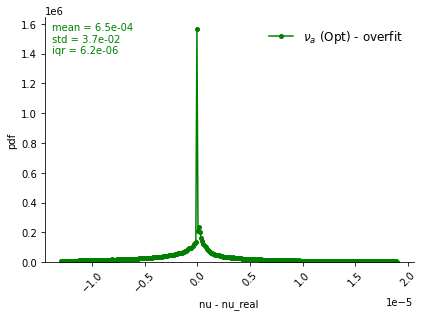

In [51]:
# parameters
figsize = (6,4.5)
dpi = 300
lw=1
ms=4
# bins='doane'
bins='auto'
# bins=2**8
a=20

data_nufit_opt = (Vs_nufit - Vs_real).ravel()
data = data_nufit_opt

q1,q2 = np.percentile(data, [a*0.5, 100-a*0.5])
print(q1, q2)
hist, edges = np.histogram(data[~((data < q1) | (data > q2))], bins=bins, density=True)
print("nbins = {}    bwidth = {}    a = {}    b = {}".format(len(edges)-1, edges[1]-edges[0], edges[0], edges[-1]))

hist_nufit_opt, edges = np.histogram(data, bins=edges, density=True)

mu_nufit_opt = np.mean(data_nufit_opt)
std_nufit_opt = np.std(data_nufit_opt)
iqr_nufit_opt = sst.iqr(data_nufit_opt)

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

X = 0.5*(edges[:-1] + edges[1:])

ax.plot(X, hist_nufit_opt, 'o-', ms=ms, color='green', label="$\\nu_a$ (Opt) - overfit")

ax.annotate("mean = {:.1e}\nstd = {:.1e}\niqr = {:.1e}".format(mu_nufit_opt, std_nufit_opt, iqr_nufit_opt), xy=(0.02, 0.98), \
            xycoords="axes fraction", ha="left", va="top", fontsize="medium", color='green')
ax.set_xlabel("nu - nu_real", fontsize="medium")
ax.set_ylabel("pdf", fontsize="medium")

ax.legend(loc='upper right', fontsize='large', frameon=False)
ax.set_ylim(0.,None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()
plt.show()
# fname = "kf_errors_pdf"
# for ext in exts:
#     filepath = figdir / (fname + ext)
#     fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
#     print("Written file: {:s}".format(str(filepath)))
# fig.clf()
# plt.close('all')